# Safety Car Prediction

https://medium.com/formula-one-forever/formula-1-data-analysis-with-fastf1-%EF%B8%8F-d451b30f3a91

In [2]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 7.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import fastf1

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import LineCollection
import fastf1.plotting

In [4]:
!pip install scikit-learn


In [5]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [10]:
file_path = "/content/drive/MyDrive/f1_project/f1_merged_all_data.csv"

df = pd.read_csv(file_path)
print(len(df))
df = df.drop_duplicates()
print(len(df))

"""df["lap_bin"] = pd.cut(
    df["lap"],
    bins=range(0, df["lap"].max() + 6, 5),
    right=False
)"""

# create bins of 5 laps labeled bi1, bi2, bi3, ...
df["bins"] = "bin" + (((df["lap"] - 1) // 5) + 1).astype(str)


101297
6172


In [45]:
df["is_street_circuit_encoded"] = df["is_street_circuit"].map({
    True: 1,
    False: 0
})

encoded_df = pd.get_dummies(
    df,
    columns=["bins"],
    prefix="is",
    drop_first=True,
    dtype=int
)

encoded_df["is_safety_car"] = df["status_code"].isin([4, 6]).astype(int)

In [46]:
encoded_df[['is_safety_car']]

,is_safety_car
0,0
1,0
2,0
3,0
4,0
...,...
100194,0
100195,0
100196,0
100197,0


In [47]:
save_path = "/content/drive/MyDrive/f1_project/encoded_dataframe.csv"
encoded_df.to_csv(save_path, index=False)

In [48]:
"""create feature vector and find which features are less important"""

# extra features to enhance accuracy
# lap-based features
encoded_df['early_race'] = (encoded_df['lap'] < 5).astype(int)  # first lap incidents
encoded_df['mid_race'] = ((encoded_df['lap'] >= 5) & (encoded_df['lap'] <= 40)).astype(int)
encoded_df['late_race'] = (encoded_df['lap'] > 40).astype(int)

# weather risk features
encoded_df['wet_conditions'] = (encoded_df['Rainfall'] > 0).astype(int)
encoded_df['temp_change'] = encoded_df.groupby(['year', 'round'])['TrackTemp'].diff().fillna(0)
encoded_df['weather_risk'] = (
    (encoded_df['Rainfall'] > 0) |
    (encoded_df['Humidity'] > 80) |
    (encoded_df['WindSpeed'] > 20)
).astype(int)

# track danger features
encoded_df['high_risk_track'] = (
    (encoded_df['is_street_circuit'] == 1) &
    (encoded_df['corners'] > 15)
).astype(int)

# historical features (lag features - did previous lap have issues?)
encoded_df['prev_lap_sc'] = encoded_df.groupby(['year', 'round'])['is_safety_car'].shift(1).fillna(0)
encoded_df['prev_2lap_sc'] = encoded_df.groupby(['year', 'round'])['is_safety_car'].shift(2).fillna(0)

# dependent variable
y = encoded_df["is_safety_car"]

drop_cols = ["lap_number"]
X = encoded_df.drop(columns=[c for c in drop_cols if c in encoded_df.columns])
X = X.drop(columns=[c for c in X.columns if c.startswith("bin")])
X = X.fillna(X.mean())
X_original = X.copy()
safety_car_column = X['is_safety_car'].copy()
X = X.drop(columns=['is_safety_car'])

In [49]:
encoded_df

,year,round,lap,status_code,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,...,is_safety_car,early_race,mid_race,late_race,wet_conditions,temp_change,weather_risk,high_risk_track,prev_lap_sc,prev_2lap_sc
0,2022,1,1,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
1,2022,1,2,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
2,2022,1,3,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
3,2022,1,4,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,1,0,0,0,0.0,0,0,0.0,0.0
4,2022,1,5,1,23.617791,29.490798,1010.385890,0.0,28.610429,124.429448,...,0,0,1,0,0,0.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100194,2025,24,54,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0
100195,2025,24,55,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0
100196,2025,24,56,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0
100197,2025,24,57,1,26.674026,60.441558,1016.727922,0.0,31.061688,223.071429,...,0,0,0,1,0,0.0,0,0,0.0,0.0


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [51]:
print("FEATURE SELECTION: Finding Less Important Features")
print("="*70)

# train a quick logistic regression on full dataset
lr_temp = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    penalty='l1',  # L1 regularization helps with feature selection
    C=1.0
)

lr_temp.fit(X, y)

# get absolute coefficients (feature importance)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_temp.coef_[0],
    'abs_coefficient': np.abs(lr_temp.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance)

FEATURE SELECTION: Finding Less Important Features

Feature Importance (Logistic Regression Coefficients):
                      feature  coefficient  abs_coefficient
36                prev_lap_sc     4.059467         4.059467
19                   is_bin15    -2.800136         2.800136
29                 early_race     2.369511         2.369511
34               weather_risk    -2.244290         2.244290
32             wet_conditions     2.038393         2.038393
17                   is_bin13    -1.516185         1.516185
20                   is_bin16    -1.495957         1.495957
14                   is_bin10     0.935022         0.935022
31                  late_race    -0.905552         0.905552
15                   is_bin11     0.561536         0.561536
27                    is_bin8    -0.532230         0.532230
13  is_street_circuit_encoded     0.420859         0.420859
37               prev_2lap_sc    -0.376918         0.376918
35            high_risk_track    -0.367107         0.

In [52]:
#drop features with low coefficient (below threshold)
COEFFICIENT_THRESHOLD = 0.05  # Adjust this threshold
features_to_drop_B = feature_importance[feature_importance['abs_coefficient'] < COEFFICIENT_THRESHOLD]['feature'].tolist()

In [53]:
for feature in features_to_drop_B:
  X = X.drop(columns=[feature])

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

safety_car_train = safety_car_column.loc[X_train.index]
safety_car_test = safety_car_column.loc[X_test.index]

# calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}



In [54]:
# regular code to find best threshold, not in use so i can compare difference in results with different thresholds
# calculate precision and recall for different thresholds
# precisions, recalls, thresholds = precision_recall_curve(y_test, predicted_probabilities)

# # optimize for F2 (emphasizes recall)


# beta = 0.5: Care more about precision (fewer false alarms)
# beta = 1.0: Equal balance (standard F1)
# beta = 2.0: Care more about recall (catch more safety cars)
# beta = 3.0: Heavily prioritize recall


# beta = 2.5
# f2_scores = (1 + beta**2) * (precisions[:-1] * recalls[:-1]) / (beta**2 * precisions[:-1] + recalls[:-1] + 1e-10)
# best_idx = np.argmax(f2_scores)
# best_threshold = thresholds[best_idx]

# # Use the optimal threshold
# predicted_labels = (predicted_probabilities > best_threshold).astype(int)

In [1]:
from imblearn.over_sampling import SMOTE  # pip install imbalanced-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


configurations = [
    {'weight': 5, 'smote_ratio': 0.2},
    {'weight': 8, 'smote_ratio': 0.3},
    {'weight': 10, 'smote_ratio': 0.3},
]

for config in configurations:
  print(f"\n{'='*70}")
  print(f"Configuration: Weight={config['weight']}, SMOTE={config['smote_ratio']}")
  print('='*70)

  # apply SMOTE to create synthetic safety car examples to oversample minority class
  smote = SMOTE(sampling_strategy=config['smote_ratio'], random_state=42)
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

  # train with class weights
  model = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        class_weight={0: 1, 1: config['weight']}  # start with 10, adjust up or down
  )

  # train on resampled data
  model.fit(X_train_resampled, y_train_resampled)

  predicted_probabilities = model.predict_proba(X_test)[:, 1]

  print("\nModel Performance at Different Thresholds:")
  print("-" * 60)

  for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    predicted_labels = (predicted_probabilities > threshold).astype(int)

    tp = ((y_test == 1) & (predicted_labels == 1)).sum()
    fp = ((y_test == 0) & (predicted_labels == 1)).sum()
    fn = ((y_test == 1) & (predicted_labels == 0)).sum()
    tn = ((y_test == 0) & (predicted_labels == 0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nThreshold {threshold:.1f}:")
    print(f"  Caught {tp}/{tp+fn} safety cars ({recall:.1%} recall)")
    print(f"  {fp} false alarms ({precision:.1%} precision)")
    print(f"  F1 Score: {f1:.3f}")

    # overall accuracy - percentage of all predictions that were correct
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # more detailed metrics
    print("\n--- Detailed Metrics ---")

    # precision - of all predicted safety cars, how many were actually safety cars?
    precision = precision_score(y_test, predicted_labels)
    print(f"Precision: {precision * 100:.2f}%") #precision minimizes false positives

    # recall - of all actual safety cars, how many did we catch?
    recall = recall_score(y_test, predicted_labels)
    print(f"Recall (Sensitivity): {recall * 100:.2f}%") #recall minimizes false negatives

    # F1 Score - harmonic mean of precision and recall
    print(f"F2-optimized threshold: {best_threshold:.3f}")
    print(f"This will catch: {recalls[best_idx]:.1%} of safety cars")
    print(f"Precision: {precisions[best_idx]:.1%}")

    # full classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, predicted_labels, target_names=['No Safety Car', 'Safety Car']))

    # confusion Matrix (more visual)
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_test, predicted_labels)
    print("\n--- Confusion Matrix ---")
    print(f"True Negatives (correctly predicted no safety car): {cm[0, 0]}")
    print(f"False Positives (incorrectly predicted safety car): {cm[0, 1]}")
    print(f"False Negatives (missed safety cars): {cm[1, 0]}")
    print(f"True Positives (correctly predicted safety car): {cm[1, 1]}")

    # calculate specific accuracies
    total_correct = cm[0, 0] + cm[1, 1]
    total_predictions = cm.sum()
    accuracy_manual = (total_correct / total_predictions) * 100



Configuration: Weight=5, SMOTE=0.2


NameError: name 'X_train' is not defined

In [55]:
# get predicted probabilities from the model
predicted_probabilities = model.predict_proba(X_test)[:, 1]

# create comparison dataframe using the probabilities you just calculated
comparison_df = pd.DataFrame({
    'actual': y_test,
    'predicted_probability': predicted_probabilities  # use the variable, not encoded_df column
})

print(comparison_df.head())

       actual  predicted_probability
40630       0               0.556439
99115       0               0.514568
63765       0               0.447855
55364       0               0.699753
59185       0               0.614397
False
['Rainfall', 'WindSpeed', 'is_street_circuit_encoded', 'is_bin10', 'is_bin11', 'is_bin12', 'is_bin13', 'is_bin15', 'is_bin16', 'is_bin2', 'is_bin3', 'is_bin4', 'is_bin6', 'is_bin7', 'is_bin8', 'is_bin9', 'early_race', 'late_race', 'wet_conditions', 'weather_risk', 'high_risk_track', 'prev_lap_sc', 'prev_2lap_sc']
['Rainfall', 'WindSpeed', 'is_street_circuit_encoded', 'is_bin10', 'is_bin11', 'is_bin12', 'is_bin13', 'is_bin15', 'is_bin16', 'is_bin2', 'is_bin3', 'is_bin4', 'is_bin6', 'is_bin7', 'is_bin8', 'is_bin9', 'early_race', 'late_race', 'wet_conditions', 'weather_risk', 'high_risk_track', 'prev_lap_sc', 'prev_2lap_sc']


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# overall Accuracy - percentage of ALL predictions that were correct
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# more detailed metrics
print("\n--- Detailed Metrics ---")

# precision - of all predicted safety cars, how many were actually safety cars?
precision = precision_score(y_test, predicted_labels)
print(f"Precision: {precision * 100:.2f}%") #precision minimizes false positives

# recall - of all actual safety cars, how many did we catch?
recall = recall_score(y_test, predicted_labels)
print(f"Recall (Sensitivity): {recall * 100:.2f}%") #recall minimizes false negatives

# F1 Score - harmonic mean of precision and recall
print(f"F2-optimized threshold: {best_threshold:.3f}")
print(f"This will catch: {recalls[best_idx]:.1%} of safety cars")
print(f"Precision: {precisions[best_idx]:.1%}")

# full classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, predicted_labels, target_names=['No Safety Car', 'Safety Car']))

# confusion Matrix (more visual)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted_labels)
print("\n--- Confusion Matrix ---")
print(f"True Negatives (correctly predicted no safety car): {cm[0, 0]}")
print(f"False Positives (incorrectly predicted safety car): {cm[0, 1]}")
print(f"False Negatives (missed safety cars): {cm[1, 0]}")
print(f"True Positives (correctly predicted safety car): {cm[1, 1]}")

# calculate specific accuracies
total_correct = cm[0, 0] + cm[1, 1]
total_predictions = cm.sum()
accuracy_manual = (total_correct / total_predictions) * 100

Accuracy: 96.03%

--- Detailed Metrics ---
Precision: 42.17%
Recall (Sensitivity): 41.18%
F2-optimized threshold: 0.901
This will catch: 43.5% of safety cars
Precision: 43.5%

--- Classification Report ---
               precision    recall  f1-score   support

No Safety Car       0.98      0.98      0.98      2384
   Safety Car       0.42      0.41      0.42        85

     accuracy                           0.96      2469
    macro avg       0.70      0.70      0.70      2469
 weighted avg       0.96      0.96      0.96      2469


--- Confusion Matrix ---
True Negatives (correctly predicted no safety car): 2336
False Positives (incorrectly predicted safety car): 48
False Negatives (missed safety cars): 50
True Positives (correctly predicted safety car): 35


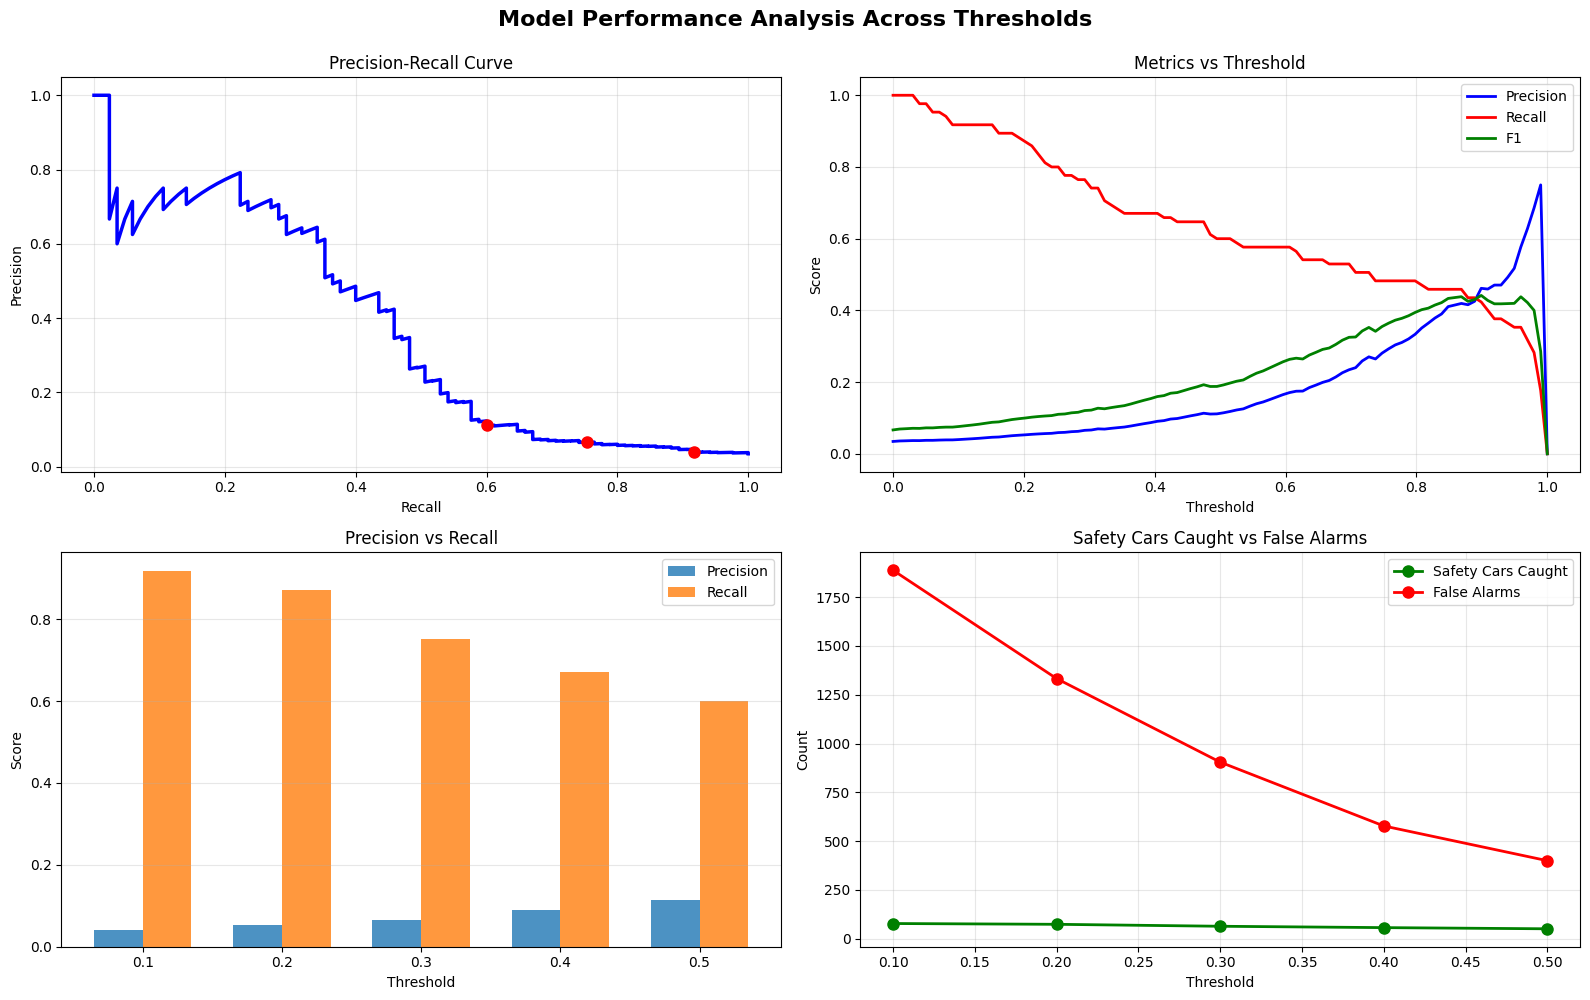

In [41]:
fig = plt.figure(figsize=(16, 10))

# mark specific thresholds
test_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
colors = ['red', 'orange', 'green', 'blue', 'purple']

# subplot 1: Precision-Recall Curve
ax1 = plt.subplot(2, 2, 1)
precisions, recalls, thresholds = precision_recall_curve(y_test, predicted_probabilities)
ax1.plot(recalls, precisions, 'b-', linewidth=2.5)
for i, thresh in enumerate(test_thresholds):
    idx = np.argmin(np.abs(thresholds - thresh))
    ax1.plot(recalls[idx], precisions[idx], 'ro', markersize=8)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.grid(True, alpha=0.3)


precisions, recalls, thresholds = precision_recall_curve(y_test, predicted_probabilities)

# create the plot
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, 'b-', linewidth=2.5)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

for i, thresh in enumerate(test_thresholds):
    # find closest threshold in the curve
    idx = np.argmin(np.abs(thresholds - thresh))
    plt.plot(recalls[idx], precisions[idx], 'o', color=colors[i],
             markersize=10, label=f'Threshold {thresh}')

# subplot 2: Metrics vs Threshold
ax2 = plt.subplot(2, 2, 2)
thresholds_range = np.linspace(0, 1, 100)
precisions_list = []
recalls_list = []
f1_list = []

for thresh in thresholds_range:
    pred = (predicted_probabilities > thresh).astype(int)
    tp = ((y_test == 1) & (pred == 1)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    fn = ((y_test == 1) & (pred == 0)).sum()

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0

    precisions_list.append(p)
    recalls_list.append(r)
    f1_list.append(f)

ax2.plot(thresholds_range, precisions_list, 'b-', linewidth=2, label='Precision')
ax2.plot(thresholds_range, recalls_list, 'r-', linewidth=2, label='Recall')
ax2.plot(thresholds_range, f1_list, 'g-', linewidth=2, label='F1')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# subplot 3: Bar Comparison
ax3 = plt.subplot(2, 2, 3)
precisions_vals = []
recalls_vals = []

for thresh in test_thresholds:
    pred = (predicted_probabilities > thresh).astype(int)
    tp = ((y_test == 1) & (pred == 1)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    fn = ((y_test == 1) & (pred == 0)).sum()

    precisions_vals.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recalls_vals.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

x = np.arange(len(test_thresholds))
width = 0.35
ax3.bar(x - width/2, precisions_vals, width, label='Precision', alpha=0.8)
ax3.bar(x + width/2, recalls_vals, width, label='Recall', alpha=0.8)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Precision vs Recall')
ax3.set_xticks(x)
ax3.set_xticklabels([f'{t:.1f}' for t in test_thresholds])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# subplot 4: Caught vs False Alarms
ax4 = plt.subplot(2, 2, 4)
safety_cars_caught = []
false_alarms = []

for thresh in test_thresholds:
    pred = (predicted_probabilities > thresh).astype(int)
    tp = ((y_test == 1) & (pred == 1)).sum()
    fp = ((y_test == 0) & (pred == 1)).sum()
    safety_cars_caught.append(tp)
    false_alarms.append(fp)

ax4.plot(test_thresholds, safety_cars_caught, 'go-', linewidth=2,
         markersize=8, label='Safety Cars Caught')
ax4.plot(test_thresholds, false_alarms, 'ro-', linewidth=2,
         markersize=8, label='False Alarms')
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Count')
ax4.set_title('Safety Cars Caught vs False Alarms')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Model Performance Analysis Across Thresholds',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

PRECISION-RECALL CURVE

The Axes:
    
    X-axis: Recall (% of Safety Cars Caught)

      Shows what percentage of all actual safety cars you successfully detected
      Left side (low recall ~0%): You're catching very few safety cars (very conservative)
      Right side (high recall ~100%): You're catching almost all safety cars (very aggressive)

    Y-axis: Precision (% of Predictions Correct)

      Shows what percentage of your "safety car" predictions were actually correct
      Top (high precision ~100%): When you predict safety car, you're almost always right (few false alarms)
      Bottom (low precision ~0%): Most of your safety car predictions are wrong (many false alarms)



Red Dot (Threshold 0.1) - Far Right

    Position: Recall ≈ 95%, Precision ≈ 5%
    Interpretation: Catches almost all safety cars (41/43), but ~95% of predictions are false alarms
    Use case: "Better safe than sorry" - when missing a safety car is extremely costly

Orange Dot (Threshold 0.2) - Right

    Position: Recall ≈ 84%, Precision ≈ 6%
    Interpretation: Catches most safety cars (36/43), still many false alarms
    Use case: Still prioritizing recall but slightly more selective

Green Dot (Threshold 0.3) - Middle-Right

    Position: Recall ≈ 70%, Precision ≈ 7%
    Interpretation: Catches 70% of safety cars (30/43), fewer false alarms
    Use case: Moderate balance - decent recall with manageable false alarm rate

Blue Dot (Threshold 0.4) - Middle

    Position: Recall ≈ 53%, Precision ≈ 9%
    Interpretation: Catches about half the safety cars (23/43), precision improving
    Use case: More balanced approach

Purple Dot (Threshold 0.5) - Middle-Left

    Position: Recall ≈ 12%, Precision ≈ 12%
    Interpretation: Only catches 12% of safety cars (5/43), but better precision
    Use case: Very conservative - only when very confident

Key Observations:
1. The Sharp Drop
The curve drops steeply as recall increases from 0.2 to 0.6. This means:

    To catch more safety cars, you pay a huge price in precision
    There's no "easy win" threshold that gives both high recall and high precision

2. The Low Precision Overall
Even at the peak (recall ≈ 0.23), precision maxes out around 83%. This suggests:

    The model struggles to distinguish safety car events from normal laps
    The features available might not strongly correlate with safety cars
    This is a very difficult prediction problem

3. The Jagged Pattern
The curve isn't smooth and instead has many small jumps. This is normal and happens because:

    There are a relatively small number of positive examples (43 safety cars)
    Each threshold change catches/misses discrete safety car events


The Good:

    The model CAN identify some safety car patterns (better than random guessing)
    You have flexibility to choose different operating points based on priorities

The Challenge:

    No threshold gives both high precision AND high recall
    To catch 70%+ of safety cars, you must accept ~93% of predictions being false alarms
    The low overall precision suggests safety cars are very hard to predict from available features

METRICS VS THRESHOLD

This shows how Precision, Recall, and F1 Score change as you adjust the prediction threshold from 0 to 1.

The Three Lines:
  Red Line - Recall

    Starts high (100%) at threshold 0.0: When threshold is 0, you predict everything as a safety car, so you catch all of them
    Gradually decreases as threshold increases: As you become more selective, you miss more safety cars
    Steep drop around threshold 0.9-1.0: Falls to 0% because you're now predicting almost nothing as safety car
    Key pattern: Smooth, consistent decline from left to right

    Reading specific points:

      Threshold 0.1: Recall ≈ 95% (catching 41/43 safety cars)
      Threshold 0.3: Recall ≈ 70% (catching 30/43 safety cars)
      Threshold 0.5: Recall ≈ 58% (catching 25/43 safety cars)

  Blue Line - Precision

    Starts very low (~5%) at threshold 0.0: When you predict everything as safety car, 95%+ are false alarms
    Gradually increases as threshold increases: As you become more selective, fewer false alarms
    Dramatic spike at threshold 0.95-1.0: Shoots up to ~70% because you're only predicting when extremely confident
    Key pattern: Slow rise, then sharp spike at the end

    Reading specific points:

      Threshold 0.1: Precision ≈ 5% (19 correct out of ~400 predictions)
      Threshold 0.3: Precision ≈ 8% (slightly better)
      Threshold 0.9: Precision ≈ 40% (much more selective)

  Green Line - F1 Score

    Starts low (~9%) at threshold 0.0: Even though recall is 100%, precision is so low that F1 is terrible
    Gradually increases to a peak around threshold 0.85-0.90: This is the "sweet spot" balancing both metrics
    Peak F1 ≈ 45% around threshold 0.87
    Then drops sharply after 0.9: Recall falls faster than precision rises
    Key pattern: Bell curve shape with peak in the high-threshold region

Key Observations:
1. The Crossover Point (around threshold 0.85-0.87):

    This is where precision and recall are most balanced
    F1 score peaks here (~45%)
    This would be the "mathematically optimal" threshold if you value precision and recall equally

2. The Gap:

    Notice precision (blue) and recall (red) never get close to each other except at the extremes
    This huge gap shows the difficulty of the problem
    You can't have both high precision AND high recall simultaneously

3. Low Overall F1:

    Even at its peak, F1 only reaches ~45%
    This indicates the model has limited predictive power
    Compare to an "excellent" model which would have F1 > 80%

PRECISION VS RECALL

A bar chart comparison of precision and recall at your five test thresholds.

Reading the Bars:

    Threshold 0.1:

      Blue bar (Precision): ~4% - Very low, lots of false alarms
      Orange bar (Recall): ~95% - Very high, catching almost all safety cars
      Interpretation: Aggressive strategy - catch everything but many false positives

    Threshold 0.2:

      Blue bar (Precision): ~6% - Still very low
      Orange bar (Recall): ~86% - Still catching most safety cars
      Interpretation: Slightly more selective but still aggressive

    Threshold 0.3:

      Blue bar (Precision): ~7% - Marginally improving
      Orange bar (Recall): ~75% - Catching 3/4 of safety cars
      Interpretation: Middle ground but precision still problematic

    Threshold 0.4:

      Blue bar (Precision): ~10% - Starting to improve
      Orange bar (Recall): ~65% - Dropping but still reasonable
      Interpretation: More balanced but still favoring recall

    Threshold 0.5:

      Blue bar (Precision): ~12% - Best precision of the five
      Orange bar (Recall): ~58% - Still catching majority of safety cars
      Interpretation: Default threshold, most balanced of your test points

Key Observations:
1. The Consistent Pattern:

    As threshold increases (0.1 → 0.5), blue bars grow taller (precision improves)
    As threshold increases, orange bars shrink (recall decreases)
    This visually confirms the precision-recall trade-off

2. The Scale Difference:

    Orange bars dwarf blue bars at every threshold
    Shows recall is MUCH higher than precision across the board
    Your model is biased toward predicting safety cars liberally

3. No "Good" Threshold:

    Even at threshold 0.5, precision is only 12%
    This means 88% of your safety car predictions are wrong
    Illustrates the fundamental challenge of this prediction task

SAFETY CARS CAUGHT VS FALSE ALARMS

The practical trade-off between catching safety cars (good) and triggering false alarms (bad).

The Two Lines:

    Green Line - Safety Cars Caught

      Shows the count of actual safety cars successfully identified
      Y-axis left side: Number of safety cars (out of 43 total)

        Reading the line:

        Threshold 0.1: ~41 caught (95% of 43)
        Threshold 0.2: ~37 caught (86% of 43)
        Threshold 0.3: ~32 caught (75% of 43)
        Threshold 0.4: ~28 caught (65% of 43)
        Threshold 0.5: ~25 caught (58% of 43)

      Pattern: Gradually declining as threshold increases (expected)

    Red Line - False Alarms

      Shows the count of false positives (predicted safety car when there wasn't one)
      Y-axis right side: Number of false alarms

        Reading the line:

        Threshold 0.1: ~1,850 false alarms (HUGE!)
        Threshold 0.2: ~1,300 false alarms (still very high)
        Threshold 0.3: ~850 false alarms (dropping)
        Threshold 0.4: ~560 false alarms (more manageable)
        Threshold 0.5: ~380 false alarms (lowest but still high)

      Pattern: Steeply declining as threshold increases (good news)
Key Observations:
1. The Dramatic Scale Difference:

    At threshold 0.1: You catch 41 safety cars but trigger 1,850 false alarms
    That's a ratio of ~45 false alarms for every 1 real safety car!
    This explains why precision is so low in the other graphs

2. The Trade-off Sweet Spots:
Aggressive (Threshold 0.1-0.2):

    Catch 90%+ of safety cars
    Deal with 1,300-1,850 false alarms
    Use case: When missing a safety car is catastrophic

    Balanced (Threshold 0.3-0.4):

    Catch 65-75% of safety cars
    Reduce false alarms to 560-850
    Use case: Reasonable compromise for most applications

    Conservative (Threshold 0.5):

    Only catch 58% of safety cars
    Minimize false alarms to ~380
    Use case: When false alarms are very costly

3. The Non-Linear Relationship:

    The red line (false alarms) drops MUCH faster than the green line (safety cars caught)
    Example: Going from 0.1 to 0.3 threshold:

    Lose only 9 safety cars (41 → 32, ~22% decrease)
    Eliminate 1,000 false alarms (1,850 → 850, ~54% decrease)


    This is good NEWS: You can significantly reduce false alarms without losing too many true positives

4. The Ideal Point:
    Looking at this graph, threshold 0.3-0.4 appears optimal:

    Threshold 0.3: Catch 32/43 (75%) with ~850 false alarms
    Threshold 0.4: Catch 28/43 (65%) with ~560 false alarms
    Best balance of catching most events while controlling false alarm rate